In [ ]:
import random
from game import Game, Player, Move
import numpy as np
from copy import copy, deepcopy
from hashlib import sha1
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import concurrent.futures
class Training_game(Game):
    def __init__(self) -> None:
        super().__init__()
    
    def move(self, move, id):
        return super()._Game__move(move[0], move[1], id)

    def set_board(self, board):
        self._board = board

    def change_board(self, move, player_id):
        current_board = copy(self._board)
        success = self.move(move, player_id)
        if success:
            return self.get_board(), current_board
        else:
            return None 

    def play(self, player1: Player, player2: Player) -> int:
            '''Play the game. Returns the winning player'''
            #print(f"player1 type {type(player1)}")
            #print(f"player1 type {type(player2)}")
            players = [player1, player2]
            winner = -1
            while winner < 0:
                self.current_player_idx += 1
                self.current_player_idx %= len(players)
                ok = False
                while not ok:
                    from_pos, slide = players[self.current_player_idx].make_move(
                        self)
                    ok = self.move([from_pos, slide], self.current_player_idx)
                winner = self.check_winner()
            player1.states.append(self._board)
            return winner


class RandomPlayer(Player):
    def __init__(self) -> None:
        super().__init__()

    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        from_pos = (random.randint(0, 4), random.randint(0, 4))
        move = random.choice([Move.TOP, Move.BOTTOM, Move.LEFT, Move.RIGHT])
        return from_pos, move


class MyPlayer(Player):
    def __init__(self, player_id, lr, gamma, num_training_games, exploit) -> None:
        super().__init__()
        self.player_value = player_id
        self.lr = lr
        self.gamma = gamma
        self.exploit = exploit
        self.states = []
        self.Q = {}
        self.games_played = 0
        self.num_training_games = num_training_games


    def make_move(self, game: 'Game') -> tuple[tuple[int, int], Move]:
        current_board = np.copy(game.get_board())
        self.states.append(current_board)
        e = np.exp(-1.5 * (self.games_played / self.num_training_games))#1 - np.log(1 + (self.games_played / self.num_training_games))
        epsilon = 0 if (self.games_played / self.num_training_games >= 1) or self.exploit else e
        #print(f"game {self.games_played} : {epsilon}")
        if (np.random.rand() < epsilon):
           # print("enters")
            #current_board = deepcopy(game.get_board())
            moves = self.get_legal_moves(current_board)
            index = random.randint(0, len(moves) - 1)
            return moves[index]

        else:
            best_move = None
            highest_eval = -np.inf
            moves = self.get_legal_moves(game.get_board())
            for move in moves:
                current_board = np.copy(game.get_board())
                new_game = Training_game()
                new_game.set_board(current_board)
                eval_weight = 1 if self.player_value == 0 else -1
                #print(f"move: {move}")
                #print(f"prev board: \n{new_game.get_board()}")
                new_board, prev_pos = new_game.change_board(move, self.player_value)
                #print(f"new board: \n{new_game.get_board()}")
                hashed_board_state = self.hash_board(new_board)
                table_result = self.Q.get(hashed_board_state)
                eval = 0 if table_result == None else table_result
                eval = eval * eval_weight
                if (eval > highest_eval):
                    highest_eval = eval
                    best_move = move
            #print(current_board)
            #print(best_move)
            return best_move
                    
                
    def train(self, num_games, opponent=None):
        r = opponent if opponent != None else RandomPlayer()
        #print(opponent)
        for _ in tqdm(range(num_games)):
            t = Training_game()
            
            if (self.player_value):
                result = t.play(r, self)
            else:
                result = t.play(self,r)
            reward = 1 if self.player_value == result else -1

            for state in reversed(self.states):
                state_to_eval = state
                hashed_state = self.hash_board(state_to_eval)
                if (self.Q.get(hashed_state) == None):
                        self.Q[hashed_state] = 0
                self.Q[hashed_state] += self.lr * (self.gamma * reward - self.Q[hashed_state])
                for _ in range(4):
                    if (self.Q.get(hashed_state) == None):
                        self.Q[hashed_state] = 0
                    self.Q[hashed_state] += self.lr * (self.gamma * reward - self.Q[hashed_state])
                    #print(f"state : \n{state}")
                    #print(f"reward {self.Q[hashed_state]}")
                    state_to_eval = np.rot90(state_to_eval)
                reward = self.Q[hashed_state] 
            self.states.clear()
            self.games_played += 1
    
            


    
    def get_legal_moves(self, board: np.ndarray):
        moves = list()
        rows, cols = board.shape
        for i in range(rows):
            if (board[i, 0] == -1):
                #print("match 1")
                pickable_piece = (0,i)
                if (i == 0):
                    insertions = (Move.BOTTOM, Move.RIGHT)
                elif (i == 4):
                    insertions = (Move.TOP, Move.RIGHT)
                else:
                    insertions = (Move.TOP, Move.BOTTOM, Move.RIGHT)
                
                for insertion in insertions:
                    #print((pickable_piece, insertion))
                    moves.append((pickable_piece, insertion))
            
            if (board[i, 4] == -1):
                #print("match 2")
                pickable_piece = (4,i)
                if (i == 0):
                    insertions = (Move.BOTTOM, Move.LEFT)
                elif (i == 4):
                    insertions = [Move.TOP, Move.LEFT]
                else:
                    insertions = (Move.TOP, Move.BOTTOM, Move.LEFT)
                for insertion in insertions:
                    #print((pickable_piece, insertion))
                    moves.append((pickable_piece, insertion))
        for j in range(cols):
            if(board[0, j] == self.player_value or board[0, j] == -1):
                #print("match 3")
                pickable_piece = (j,0)
                if(j == 0):
                    insertions = (Move.BOTTOM, Move.RIGHT)
                elif (j == 4):
                    insertions = (Move.BOTTOM, Move.LEFT)
                else:
                    insertions = (Move.LEFT, Move.RIGHT, Move.BOTTOM)
                for insertion in insertions:
                    #print((pickable_piece, insertion))
                    moves.append((pickable_piece, insertion))
            if(board[4, j] == self.player_value or board[4, j] == -1):
                #print("match 4")
                pickable_piece = (j,4)
                if (j == 0):
                    insertions = (Move.TOP, Move.RIGHT)
                elif (j == 4):
                    insertions = (Move.TOP, Move.LEFT)
                else:
                    insertions = (Move.LEFT, Move.RIGHT, Move.TOP)
                for insertion in insertions:
                    #print((pickable_piece, insertion))
                    moves.append((pickable_piece, insertion))
        return moves

    def hash_board(self, board):
        sha_hash = sha1()
        sha_hash.update(board.tobytes())
        return sha_hash.hexdigest()

    def epsilon(self, n):
        xr = 1 - np.log2(1+(n / self.num_training_games))
        epsilon = xr if n < self.num_training_games else 0
        return epsilon


In [ ]:
def simulate_games(num_simulation_games, agent: MyPlayer):
    opponent = RandomPlayer()
    results = []
    #print(agent)
    for _ in tqdm(range(num_simulation_games)):
        t = Training_game()
        result = t.play(agent, opponent)
        results.append(result)
    return results.count(agent.player_value) / num_simulation_games


In [ ]:
def train_agains_rl_agent(num_games, batch_num):
    random_opponent = RandomPlayer()

    agent2 = MyPlayer(0, 0.2, 0.9, batch_num, False)
    games_simulated = 0
    x = []
    winrates = []
    while (games_simulated // batch_num) <(num_games // batch_num):
        if (games_simulated % batch_num == 0):
            x.append(games_simulated)
            agent2.exploit = True
            print(games_simulated)
            winrate = simulate_games(1000, agent2)
            winrates.append(winrate)
            print(winrate)
        agent2.exploit = False
        #print("trains")
        agent2.train(batch_num)
        games_simulated += batch_num
    
    return winrates, x

In [90]:
num_training_games = 20000
player_id = 0
num_epochs = 100
player = MyPlayer(player_id, 0.01, 0.9, num_training_games, False)

100%|██████████| 1000/1000 [00:08<00:00, 112.61it/s]


player winrate: 0.474


100%|██████████| 1000/1000 [00:07<00:00, 129.23it/s]


player winrate: 0.617


100%|██████████| 1000/1000 [00:06<00:00, 143.68it/s]


player winrate: 0.681


100%|██████████| 1000/1000 [00:07<00:00, 141.06it/s]


player winrate: 0.674


100%|██████████| 1000/1000 [00:06<00:00, 147.50it/s]


player winrate: 0.672


100%|██████████| 1000/1000 [00:06<00:00, 154.27it/s]


player winrate: 0.7


100%|██████████| 1000/1000 [00:06<00:00, 154.40it/s]


player winrate: 0.738


100%|██████████| 1000/1000 [00:06<00:00, 160.18it/s]


player winrate: 0.715


100%|██████████| 1000/1000 [00:06<00:00, 157.67it/s]


player winrate: 0.727


100%|██████████| 1000/1000 [00:06<00:00, 148.00it/s]


player winrate: 0.709


100%|██████████| 1000/1000 [00:06<00:00, 158.40it/s]


player winrate: 0.732


100%|██████████| 1000/1000 [00:06<00:00, 162.08it/s]


player winrate: 0.764


100%|██████████| 1000/1000 [00:06<00:00, 163.58it/s]


player winrate: 0.753


100%|██████████| 1000/1000 [00:05<00:00, 167.15it/s]


player winrate: 0.752


100%|██████████| 1000/1000 [00:05<00:00, 167.34it/s]


player winrate: 0.771


100%|██████████| 1000/1000 [00:06<00:00, 165.68it/s]


player winrate: 0.767


100%|██████████| 1000/1000 [00:05<00:00, 169.13it/s]


player winrate: 0.78


100%|██████████| 1000/1000 [00:06<00:00, 163.23it/s]


player winrate: 0.782


100%|██████████| 1000/1000 [00:05<00:00, 174.43it/s]


player winrate: 0.771


100%|██████████| 1000/1000 [00:05<00:00, 171.35it/s]


player winrate: 0.777


100%|██████████| 1000/1000 [00:05<00:00, 169.66it/s]


player winrate: 0.808


100%|██████████| 1000/1000 [00:05<00:00, 178.15it/s]


player winrate: 0.792


100%|██████████| 1000/1000 [00:05<00:00, 178.78it/s]


player winrate: 0.792


100%|██████████| 1000/1000 [00:05<00:00, 170.85it/s]


player winrate: 0.789


100%|██████████| 1000/1000 [00:05<00:00, 175.19it/s]


player winrate: 0.789


100%|██████████| 1000/1000 [00:05<00:00, 170.42it/s]


player winrate: 0.797


100%|██████████| 1000/1000 [00:05<00:00, 184.02it/s]


player winrate: 0.816


100%|██████████| 1000/1000 [00:05<00:00, 169.80it/s]


player winrate: 0.813


100%|██████████| 1000/1000 [00:05<00:00, 172.53it/s]


player winrate: 0.802


100%|██████████| 1000/1000 [00:05<00:00, 173.44it/s]


player winrate: 0.789


100%|██████████| 1000/1000 [00:05<00:00, 171.97it/s]


player winrate: 0.798


100%|██████████| 1000/1000 [00:05<00:00, 178.62it/s]


player winrate: 0.81


100%|██████████| 1000/1000 [00:05<00:00, 169.76it/s]


player winrate: 0.803


100%|██████████| 1000/1000 [00:05<00:00, 177.61it/s]


player winrate: 0.814


100%|██████████| 1000/1000 [00:06<00:00, 166.34it/s]


player winrate: 0.796


100%|██████████| 1000/1000 [00:05<00:00, 169.85it/s]


player winrate: 0.785


100%|██████████| 1000/1000 [00:05<00:00, 169.83it/s]


player winrate: 0.801


100%|██████████| 1000/1000 [00:05<00:00, 177.88it/s]


player winrate: 0.814


100%|██████████| 1000/1000 [00:05<00:00, 184.48it/s]


player winrate: 0.833


100%|██████████| 1000/1000 [00:06<00:00, 156.92it/s]


player winrate: 0.798


100%|██████████| 1000/1000 [00:05<00:00, 172.35it/s]


player winrate: 0.799


100%|██████████| 1000/1000 [00:05<00:00, 180.18it/s]


player winrate: 0.804


100%|██████████| 1000/1000 [00:05<00:00, 181.08it/s]


player winrate: 0.809


100%|██████████| 1000/1000 [00:05<00:00, 182.55it/s]


player winrate: 0.803


100%|██████████| 1000/1000 [00:05<00:00, 185.50it/s]


player winrate: 0.825


100%|██████████| 1000/1000 [00:05<00:00, 184.18it/s]


player winrate: 0.833


100%|██████████| 1000/1000 [00:05<00:00, 190.50it/s]


player winrate: 0.829


100%|██████████| 1000/1000 [00:05<00:00, 186.96it/s]


player winrate: 0.836


100%|██████████| 1000/1000 [00:05<00:00, 185.58it/s]


player winrate: 0.83


100%|██████████| 1000/1000 [00:05<00:00, 180.35it/s]


player winrate: 0.814


100%|██████████| 1000/1000 [00:05<00:00, 185.14it/s]


player winrate: 0.822


100%|██████████| 1000/1000 [00:05<00:00, 187.79it/s]


player winrate: 0.823


100%|██████████| 1000/1000 [00:05<00:00, 173.94it/s]


player winrate: 0.802


100%|██████████| 1000/1000 [00:05<00:00, 188.88it/s]


player winrate: 0.83


100%|██████████| 1000/1000 [00:05<00:00, 185.02it/s]


player winrate: 0.821


100%|██████████| 1000/1000 [00:05<00:00, 187.74it/s]


player winrate: 0.821


100%|██████████| 1000/1000 [00:05<00:00, 187.70it/s]


player winrate: 0.822


100%|██████████| 1000/1000 [00:05<00:00, 186.95it/s]


player winrate: 0.813


100%|██████████| 1000/1000 [00:05<00:00, 187.92it/s]


player winrate: 0.817


100%|██████████| 1000/1000 [00:05<00:00, 186.19it/s]


player winrate: 0.853


100%|██████████| 1000/1000 [00:05<00:00, 186.18it/s]


player winrate: 0.828


100%|██████████| 1000/1000 [00:05<00:00, 180.47it/s]


player winrate: 0.841


100%|██████████| 1000/1000 [00:05<00:00, 184.48it/s]


player winrate: 0.826


100%|██████████| 1000/1000 [00:05<00:00, 180.46it/s]


player winrate: 0.797


100%|██████████| 1000/1000 [00:05<00:00, 185.78it/s]


player winrate: 0.869


100%|██████████| 1000/1000 [00:05<00:00, 181.17it/s]


player winrate: 0.84


100%|██████████| 1000/1000 [00:05<00:00, 189.12it/s]


player winrate: 0.849


100%|██████████| 1000/1000 [00:05<00:00, 180.02it/s]


player winrate: 0.854


100%|██████████| 1000/1000 [00:05<00:00, 184.84it/s]


player winrate: 0.833


100%|██████████| 1000/1000 [00:05<00:00, 187.30it/s]


player winrate: 0.838


100%|██████████| 1000/1000 [00:05<00:00, 181.51it/s]


player winrate: 0.849


100%|██████████| 1000/1000 [00:05<00:00, 183.23it/s]


player winrate: 0.824


100%|██████████| 1000/1000 [00:05<00:00, 186.82it/s]


player winrate: 0.852


100%|██████████| 1000/1000 [00:05<00:00, 177.83it/s]


player winrate: 0.842


100%|██████████| 1000/1000 [00:05<00:00, 181.89it/s]


player winrate: 0.84


100%|██████████| 1000/1000 [00:05<00:00, 185.16it/s]


player winrate: 0.817


100%|██████████| 1000/1000 [00:05<00:00, 184.80it/s]


player winrate: 0.838


100%|██████████| 1000/1000 [00:05<00:00, 182.31it/s]


player winrate: 0.839


100%|██████████| 1000/1000 [00:05<00:00, 179.36it/s]


player winrate: 0.831


100%|██████████| 1000/1000 [00:05<00:00, 190.57it/s]


player winrate: 0.853


100%|██████████| 1000/1000 [00:05<00:00, 184.59it/s]


player winrate: 0.844


100%|██████████| 1000/1000 [00:05<00:00, 190.73it/s]


player winrate: 0.848


100%|██████████| 1000/1000 [00:05<00:00, 190.95it/s]


player winrate: 0.833


100%|██████████| 1000/1000 [00:04<00:00, 200.48it/s]


player winrate: 0.848


100%|██████████| 1000/1000 [00:05<00:00, 196.93it/s]


player winrate: 0.856


100%|██████████| 1000/1000 [00:05<00:00, 187.96it/s]


player winrate: 0.847


100%|██████████| 1000/1000 [00:05<00:00, 196.53it/s]


player winrate: 0.847


100%|██████████| 1000/1000 [00:05<00:00, 188.40it/s]


player winrate: 0.857


100%|██████████| 1000/1000 [00:05<00:00, 193.35it/s]


player winrate: 0.869


100%|██████████| 1000/1000 [00:04<00:00, 201.03it/s]


player winrate: 0.856


100%|██████████| 1000/1000 [00:05<00:00, 181.80it/s]


player winrate: 0.848


100%|██████████| 1000/1000 [00:05<00:00, 176.61it/s]


player winrate: 0.855


100%|██████████| 1000/1000 [00:05<00:00, 184.83it/s]


player winrate: 0.864


100%|██████████| 1000/1000 [00:05<00:00, 187.82it/s]


player winrate: 0.871


100%|██████████| 1000/1000 [00:05<00:00, 198.05it/s]


player winrate: 0.872


100%|██████████| 1000/1000 [00:05<00:00, 189.95it/s]


player winrate: 0.867


100%|██████████| 1000/1000 [00:05<00:00, 167.22it/s]


player winrate: 0.859


100%|██████████| 1000/1000 [00:04<00:00, 200.76it/s]


player winrate: 0.878


100%|██████████| 1000/1000 [00:05<00:00, 167.48it/s]


player winrate: 0.855


100%|██████████| 1000/1000 [00:04<00:00, 208.37it/s]


player winrate: 0.868


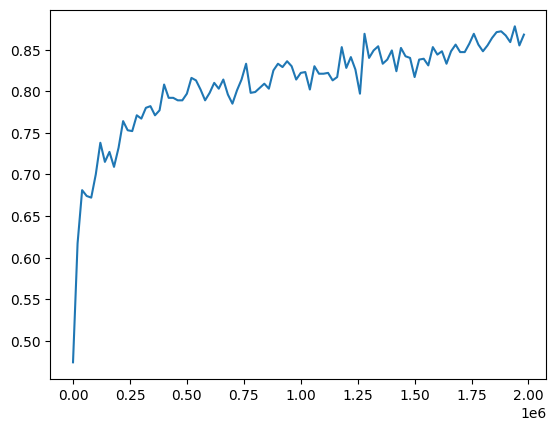

In [91]:
x = []
w = []
for i in range(num_epochs):
    player.train(num_training_games)
    r = RandomPlayer()
    num_games = 1000
    results = []
    for _ in tqdm(range(num_games)):
        r2 = RandomPlayer()
        t = Game()
        result = t.play(player,r)
        results.append(result)

    print(f"player winrate: {results.count(player_id) / num_games}")
    #print(f"random winrate: {results.count(1-player_id) / num_games}")

    w.append(results.count(player_id) / num_games)
    x.append(i * num_training_games)
    
plt.plot(x, w)


In [ ]:
player.train(num_training_games)

In [ ]:
print(w)

In [ ]:
# num_training_games = 100000
# player.num_training_games = 100000
# print(1-np.log2(1+10000/10000))
# x = [i for i in range(num_training_games+100)]
# xr = [player.epsilon(i) for i in range(num_training_games+100)]

In [ ]:
# plt.plot(x, xr)

In [ ]:
# winrate, x = train_agains_rl_agent(100000, 10000)

In [ ]:
plt.plot(x, winrate)
plt.ylim(0,1)
print(winrate)


In [107]:

# Specify the file path (assuming you want to write to a file in the same directory)
file_path = 'Q2_000_000.json'


# Open the file for writing
with open(file_path, 'w') as file:
    # Use json.dump to write the dictionary to the file in JSON format
    json.dump(player.Q, file, indent=2)  # The indent parameter is optional and adds indentation for better readability

# Now, loaded_dict contains the dictionary loaded from the JSON file



In [ ]:
print(len(player.Q))

In [102]:
result_list = []
player.exploit = True
player.player_value = 1
for i in tqdm(range(10000)):
    t = Game()
    r_p = RandomPlayer()
    res = t.play(r_p,player)
    result_list.append(res)
    

100%|██████████| 10000/10000 [01:38<00:00, 101.35it/s]


(array([3923., 6077.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

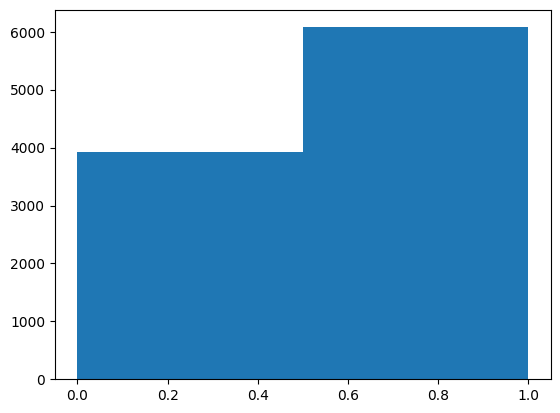

In [106]:
plt.hist(result_list, 2)

In [104]:
print(f"winrate {result_list.count(1) / 10000}")

winrate 0.6077


In [108]:
with open("q2_000_000.json", "r") as file:
    q_table = json.load(file)


In [109]:
print(len(q_table))

10891207


In [114]:
num_training_games = 1000
player_id = 0
num_epochs = 100
my_player = MyPlayer(player_id, 0.01, 0.9, num_training_games, False)
my_player.Q = q_table

opponent_agent = MyPlayer(1, 0, 0, 2000000, True)
opponent_agent.Q = q_table
x = []
w = []
for i in range(num_epochs):
    my_player.train(num_training_games)
    num_games = 1000
    results = []
    for _ in tqdm(range(num_games)):
        r2 = RandomPlayer()
        t = Game()
        result = t.play(my_player,r)
        results.append(result)

    print(f"player winrate: {results.count(player_id) / num_games}")
    #print(f"random winrate: {results.count(1-player_id) / num_games}")

    w.append(results.count(player_id) / num_games)
    x.append(i * num_training_games)
    
plt.plot(x, w)


100%|██████████| 1000/1000 [00:09<00:00, 108.85it/s]


player winrate: 0.0


100%|██████████| 1000/1000 [00:09<00:00, 108.06it/s]


player winrate: 0.0


100%|██████████| 1000/1000 [00:14<00:00, 68.64it/s]


player winrate: 0.0


100%|██████████| 1000/1000 [00:09<00:00, 109.25it/s]


player winrate: 0.0


 33%|███▎      | 334/1000 [00:03<00:06, 107.47it/s]


KeyboardInterrupt: 